## Entrenamiento de los modelos 

In [5]:
import json
import pickle
import numpy as np
import logging
import os
import warnings
import joblib
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             precision_score, recall_score, roc_auc_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")


In [2]:
def read_csv(file_name=str, path="D:/Repositorio/Proyecto-titanic/data_processed")->pd.DataFrame:

    #This function read the csv file
    return pd.read_csv(os.path.join(path, file_name))

def one_hot_encoding(data, columns):
    """
    Esta función aplica one-hot encoding a las columnas especificadas en un DataFrame.
    
    Args:
        data (DataFrame): DataFrame de pandas que contiene los datos.
        columns (list): Lista de nombres de columnas a codificar en one-hot encoding.
    
    Returns:
        DataFrame: DataFrame con las columnas codificadas en one-hot encoding.
    """
    # Convertir las columnas especificadas a tipo string
    data[columns] = data[columns].astype(str)
    
    # Aplicar one-hot encoding
    data_encoded = pd.get_dummies(data, columns=columns, drop_first=True)
    
    # Convertir las columnas codificadas a tipo int
    for column in data_encoded.columns:
        data_encoded[column] = data_encoded[column].astype(int)
    
    return data_encoded

In [44]:
data_titamic = read_csv("titanic.csv")
data_titamic.head(3)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250


In [45]:
data_titamic_encoded = pd.get_dummies(data_titamic, columns=["Sex"], drop_first=True, dtype=int)
data_titamic_encoded.head(3)

,Survived,Pclass,Name,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_male
0,0,3,Mr. Owen Harris Braund,22.0,1,0,7.2500,1
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,38.0,1,0,71.2833,0
2,1,3,Miss. Laina Heikkinen,26.0,0,0,7.9250,0


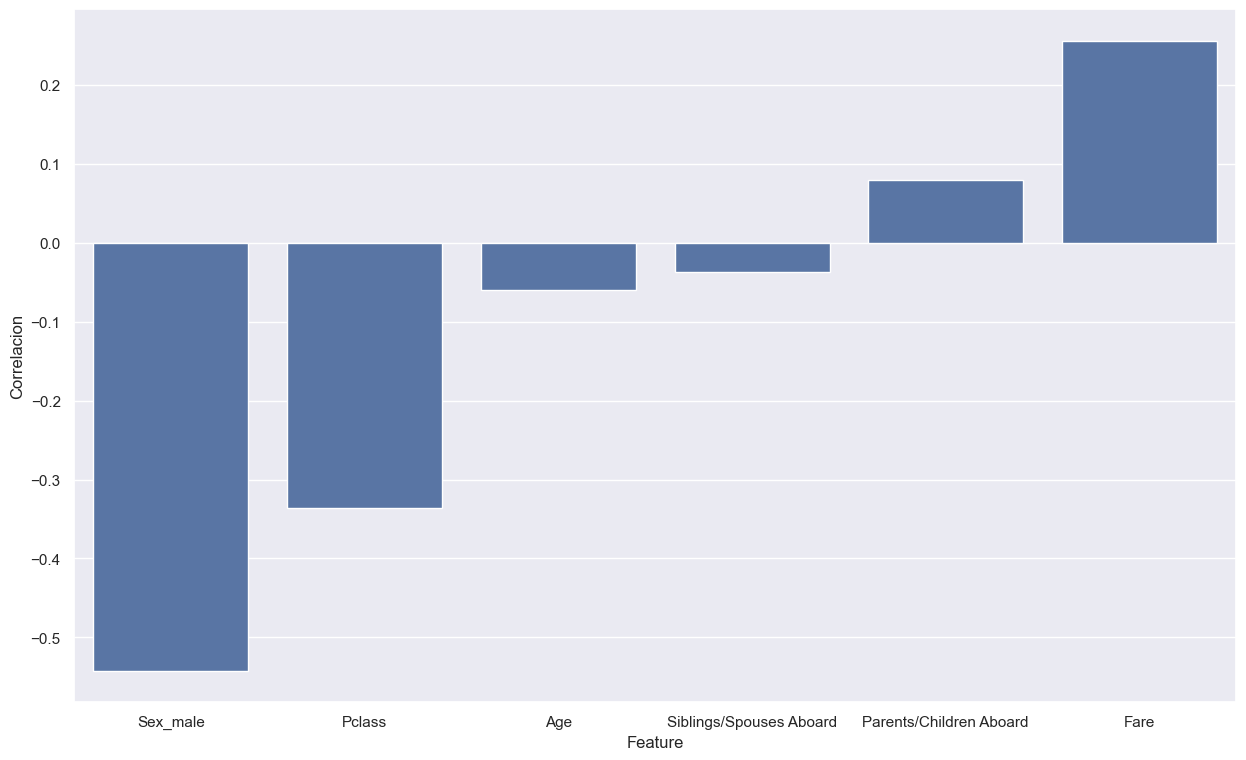

In [15]:
data_numeric = data_titamic_encoded.select_dtypes(include=['float', "int"])
fig = plt.figure(figsize=(15,9))
data_corr = pd.DataFrame(data_numeric.corr()['Survived'].sort_values()[:-1]).reset_index()
sns.barplot(data=data_corr, x = 'index', y = 'Survived')
plt.xlabel('Feature')
plt.ylabel('Correlacion')
plt.xticks(rotation = 360)
plt.show()

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Suvirved_titanic")


INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.


<Experiment: artifact_location='file:///d:/Repositorio/Proyecto-titanic/mlruns/1', creation_time=1714756562262, experiment_id='1', last_update_time=1714756562262, lifecycle_stage='active', name='Suvirved_titanic', tags={}>

In [16]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Suvirved_titanic_Entr_3")

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
2024/05/10 10:32:01 INFO mlflow.tracking.fluent: Experiment with name 'Suvirved_titanic_Entr_3' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Repositorio/Proyecto-titanic/mlruns/3', creation_time=1715351521374, experiment_id='3', last_update_time=1715351521374, lifecycle_stage='active', name='Suvirved_titanic_Entr_3', tags={}>

In [43]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Suvirved_titanic_Entr_4")

2024/05/10 11:28:45 INFO mlflow.tracking.fluent: Experiment with name 'Suvirved_titanic_Entr_4' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Repositorio/Proyecto-titanic/mlruns/4', creation_time=1715354925292, experiment_id='4', last_update_time=1715354925292, lifecycle_stage='active', name='Suvirved_titanic_Entr_4', tags={}>

In [46]:


def data_transform(df: pd.DataFrame):
    #Thhis function transform the data into X and y
    X = df.drop(["Survived","Name"], axis=1)
    y = df.Survived
    return X, y


def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    filepath = os.path.join("D:/Repositorio/Proyecto-titanic", "data_processed", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
        
def split_train_test(
    X: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    This function splits the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
    Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train.values, y_test.values

def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
      model (object): model
      name_model (str): name of the model
      developer (str): developer name
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
     Returns:
      metric (list): list with the metrics"""
    
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba[:,1], average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba[:,1], average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info("ROC AUC Score Train: %.2f", roc_auc_score_train)
        logger.info("ROC AUC Score Test: %.2f", roc_auc_score_test)

        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )
        mlflow.log_metric("Train Accuracy", acc_score_train)
        mlflow.log_metric("Test Accuracy", acc_score_test)
        mlflow.log_metric("F-score_train", fscore_train)
        mlflow.log_metric("F-score_test", fscore_test)
        
        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(8, 4))


        cm = confusion_matrix(y_test, y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric
    
    
def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search

def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)



In [48]:

X, y = data_transform(data_titamic_encoded)
X_train, X_test, y_train, y_test = split_train_test(X, y)

print(data_titamic.shape)
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)

INFO:__main__:data saved successfully in pickle files


(887, 8)
(887, 6)
(887,)
(620, 6)
(620,)


#### Modelo de Regresion logistica

Experimento 1 se realizo un experiemto sin busqueda de los mejores parametros
Experimento 2 se realizo con la busqueda de los mejorees parametros
Para el experimento 3, eliminaremos las columnas menos relevantes, y aplicaremos un revalanceo de los datos con la tecnica de smote.
Experimento 4 no eliminaremos las columnas, realizaremos un escalamiento de los datos y tambien sera se realizara el balanceo de los datos

In [49]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [50]:
y_train_series = pd.Series(y_train)

# Contar las ocurrencias de cada valor
count_series = y_train_series.value_counts()

# Renombrar la serie para que tenga el nombre 'count'
count_series.name = 'count'

print(count_series)

1    379
0    379
Name: count, dtype: int64


In [51]:
scaler = StandardScaler()

# Ajustar el scaler a tus datos de entrenamiento y transformarlos
X_train = scaler.fit_transform(X_train)

# Si tienes un conjunto de datos de prueba, también debes transformarlo
X_test = scaler.transform(X_test)

In [55]:
pd.DataFrame(X_train).head(3)

,0,1,2,3,4,5
0,-1.408212,1.582122,-0.462190,-0.482837,-0.113891,0.933598
1,-0.236505,0.528094,-0.462190,-0.482837,-0.670336,0.933598
2,0.935201,-0.104323,1.452238,-0.482837,-0.246161,-1.071125


INFO:__main__:ROC AUC Score Train: 0.89
INFO:__main__:ROC AUC Score Test: 0.82


Train Accuracy:  0.83
Test Accuracy:  0.78
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       379
           1       0.84      0.82      0.83       379

    accuracy                           0.83       758
   macro avg       0.83      0.83      0.83       758
weighted avg       0.83      0.83      0.83       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       166
           1       0.74      0.65      0.69       101

    accuracy                           0.78       267
   macro avg       0.77      0.76      0.76       267
weighted avg       0.78      0.78      0.78       267



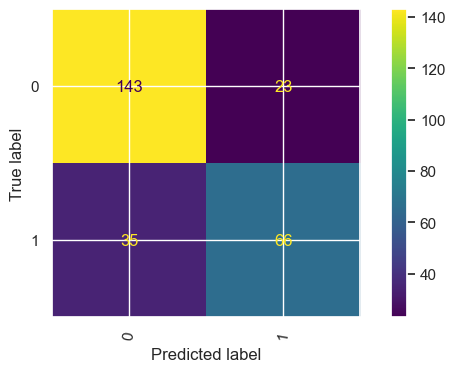

[0.89, 0.82, 0.83, 0.78, 0.83, 0.78, 0.83, 0.78, 0.83, 0.78]

In [56]:
log_reg = LogisticRegression(random_state=40)
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

#### Modelo Multinomial Naive Bayes

Este modelo no admite datos negativos. como realizamos en el entrenamiento 4, un escalamiento de los datos, no se entrenara con este modelo en especifico

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Decision tree Clasifier

INFO:__main__:ROC AUC Score Train: 1.00
INFO:__main__:ROC AUC Score Test: 0.74


Train Accuracy:  0.99
Test Accuracy:  0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       379
           1       1.00      0.98      0.99       379

    accuracy                           0.99       758
   macro avg       0.99      0.99      0.99       758
weighted avg       0.99      0.99      0.99       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       166
           1       0.68      0.68      0.68       101

    accuracy                           0.76       267
   macro avg       0.75      0.75      0.75       267
weighted avg       0.76      0.76      0.76       267



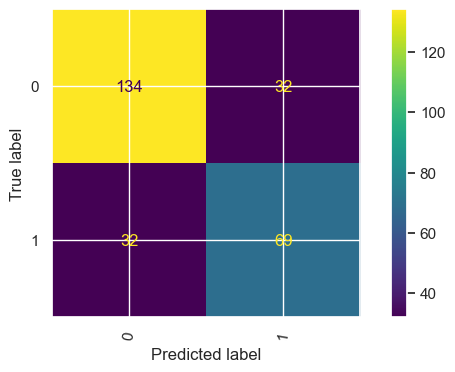

[1.0, 0.74, 0.99, 0.76, 0.99, 0.76, 0.99, 0.76, 0.99, 0.76]

In [58]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
display_classification_report(model=dtc, 
                              name_model="DecisionTreeClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Suport Vector Machine

INFO:__main__:ROC AUC Score Train: 0.92
INFO:__main__:ROC AUC Score Test: 0.82


Train Accuracy:  0.86
Test Accuracy:  0.79
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       379
           1       0.89      0.82      0.85       379

    accuracy                           0.86       758
   macro avg       0.86      0.86      0.86       758
weighted avg       0.86      0.86      0.86       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       166
           1       0.78      0.63      0.70       101

    accuracy                           0.79       267
   macro avg       0.79      0.76      0.77       267
weighted avg       0.79      0.79      0.79       267



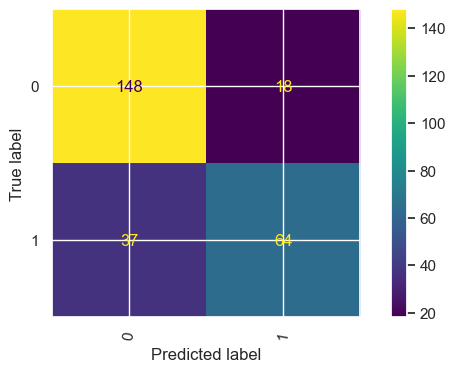

[0.92, 0.82, 0.86, 0.79, 0.86, 0.79, 0.86, 0.79, 0.86, 0.79]

In [59]:
svc = SVC(gamma="auto", probability=True, random_state=42)
svc.fit(X_train, y_train)
display_classification_report(model=svc, 
                              name_model="SVC", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Ramdon Forest

INFO:__main__:ROC AUC Score Train: 0.89
INFO:__main__:ROC AUC Score Test: 0.83


Train Accuracy:  0.83
Test Accuracy:  0.78
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       379
           1       0.86      0.79      0.82       379

    accuracy                           0.83       758
   macro avg       0.83      0.83      0.83       758
weighted avg       0.83      0.83      0.83       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       166
           1       0.76      0.61      0.68       101

    accuracy                           0.78       267
   macro avg       0.77      0.75      0.75       267
weighted avg       0.78      0.78      0.77       267



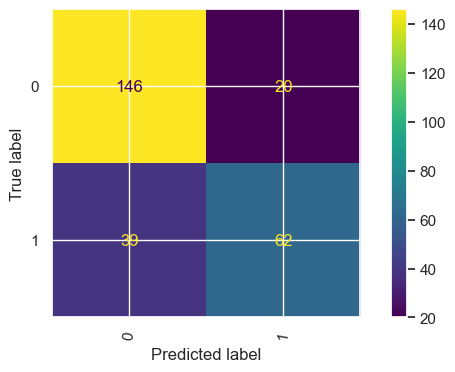

[0.89, 0.83, 0.83, 0.78, 0.83, 0.78, 0.83, 0.78, 0.83, 0.77]

In [60]:
rf = RandomForestClassifier(max_depth=2,random_state=42)
rf.fit(X_train, y_train)
display_classification_report(model= rf,
                              name_model="RandomForestClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)


#### Redes neuronales artificiales

INFO:__main__:ROC AUC Score Train: 0.93
INFO:__main__:ROC AUC Score Test: 0.84


Train Accuracy:  0.87
Test Accuracy:  0.8
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       379
           1       0.91      0.81      0.86       379

    accuracy                           0.87       758
   macro avg       0.87      0.87      0.86       758
weighted avg       0.87      0.87      0.86       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       166
           1       0.81      0.62      0.70       101

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267



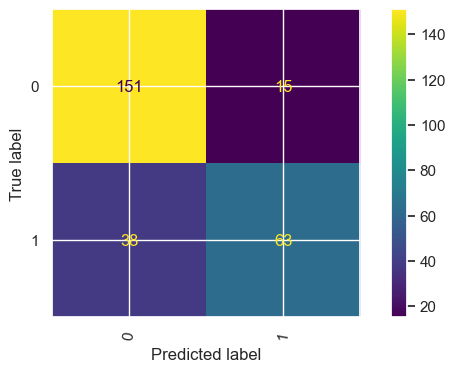

[0.93, 0.84, 0.87, 0.8, 0.87, 0.8, 0.87, 0.8, 0.86, 0.8]

In [61]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)
display_classification_report(model=mlp, 
                              name_model="MLPClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Modelo de regresion logistica con GridSearchCV

In [35]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


INFO:__main__:ROC AUC Score Train: 0.90
INFO:__main__:ROC AUC Score Test: 0.82


Best Score:  0.8259149529452771
Best Hyperparameters:  {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 300, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001, 'warm_start': True}
Train Accuracy:  0.83
Test Accuracy:  0.78
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       379
           1       0.84      0.82      0.83       379

    accuracy                           0.83       758
   macro avg       0.83      0.83      0.83       758
weighted avg       0.83      0.83      0.83       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       166
           1       0.74      0.65      0.69       101

    accuracy                           0.78       267
   macro avg       0.77      0.76      0.76       267
weighted avg       0.78      0.78      0.78       267



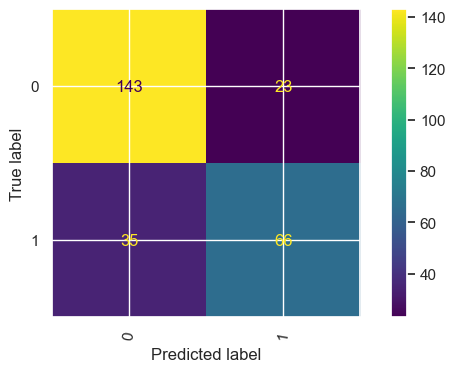

[0.9, 0.82, 0.83, 0.78, 0.83, 0.78, 0.83, 0.78, 0.83, 0.78]

In [62]:
log_reg = LogisticRegression()

params_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False],
    'warm_start': [True, False]
}


grid_search_log = grid_search(log_reg, folds, params_grid, scoring="accuracy")
grid_search_log.fit(X_train, y_train)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Jose Luis", 
                              X_train=X_train,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

#### Modelo Multinomial bayes con gridSearchCv

Fitting 5 folds for each of 32 candidates, totalling 160 fits


INFO:__main__:ROC AUC Score Train: 0.79
INFO:__main__:ROC AUC Score Test: 0.77


Best Score:  0.7348466364586965
Best Hyperparameters:  {'alpha': 0.1, 'class_prior': [0.1, 0.9], 'fit_prior': True}
Train Accuracy:  0.75
Test Accuracy:  0.72
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.81      0.65      0.72       379
           1       0.71      0.85      0.77       379

    accuracy                           0.75       758
   macro avg       0.76      0.75      0.74       758
weighted avg       0.76      0.75      0.74       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.67      0.75       166
           1       0.60      0.80      0.68       101

    accuracy                           0.72       267
   macro avg       0.72      0.74      0.72       267
weighted avg       0.75      0.72      0.72       267



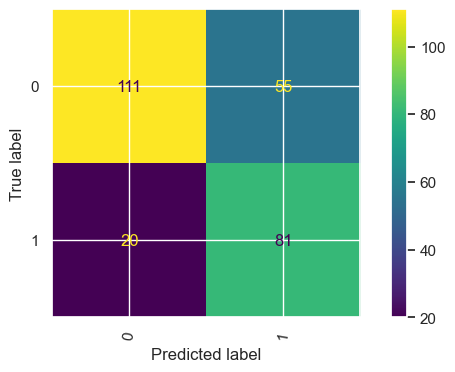

[0.79, 0.77, 0.75, 0.72, 0.76, 0.75, 0.75, 0.72, 0.74, 0.72]

In [37]:
mnb = MultinomialNB()
params_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Parámetro de suavizado de Laplace
    'fit_prior': [True, False],  # Si se debe aprender o no las probabilidades a priori de clase
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7]]  # Probabilidades a priori de clase
}
grid_search_mnb = grid_search(mnb, folds, params_grid, scoring="accuracy")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model= grid_search_mnb,
                              name_model="MultinomialNBCV",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Decision Tree Clasifier con GridSearchCV

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


INFO:__main__:ROC AUC Score Train: 0.95
INFO:__main__:ROC AUC Score Test: 0.75


Best Score:  0.8588009759498083
Best Hyperparameters:  {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': None, 'splitter': 'best'}
Train Accuracy:  0.87
Test Accuracy:  0.72
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       379
           1       0.90      0.84      0.87       379

    accuracy                           0.87       758
   macro avg       0.88      0.87      0.87       758
weighted avg       0.88      0.87      0.87       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       166
           1       0.66      0.54      0.60       101

    accuracy                           0.72       267
   macro avg       0.71      0.69      0.69       267
weighted avg       0.72      0.72      0.72       267



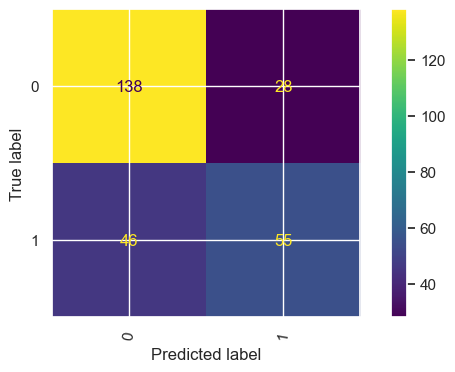

[0.95, 0.75, 0.87, 0.72, 0.88, 0.72, 0.87, 0.72, 0.87, 0.72]

In [63]:
dtc = DecisionTreeClassifier()
params_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Criterio para medir la calidad de una división
    'splitter': ['best', 'random'],  # Estrategia utilizada para elegir la división en cada nodo
    'max_depth': [None, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas para estar en un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'random_state': [None, 42],  # Controla la aleatoriedad del estimador
    'class_weight': [None, 'balanced'] # Pesos asociados con las clases
}
grid_search_dtc = grid_search(dtc,folds, params_grid, scoring=("accuracy"))
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(model= grid_search_dtc,
                              name_model="DecisionTreeClassifierCV",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Suport Vector Machine con GridSearchCV

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


INFO:__main__:ROC AUC Score Train: 0.90
INFO:__main__:ROC AUC Score Test: 0.79


Best Score:  0.8535901010805158
Best Hyperparameters:  {'C': 1.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 200, 'shrinking': True, 'tol': 0.001}
Train Accuracy:  0.86
Test Accuracy:  0.8
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       379
           1       0.89      0.83      0.86       379

    accuracy                           0.86       758
   macro avg       0.86      0.86      0.86       758
weighted avg       0.86      0.86      0.86       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       166
           1       0.79      0.64      0.71       101

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267



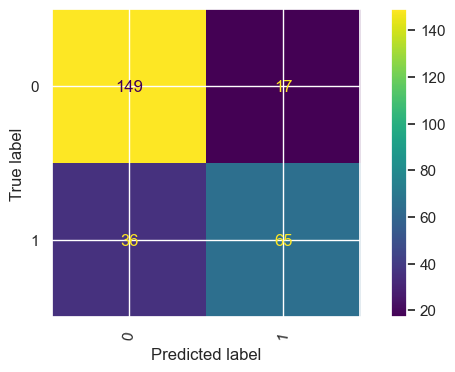

[0.9, 0.79, 0.86, 0.8, 0.86, 0.8, 0.86, 0.8, 0.86, 0.8]

In [64]:
svc = SVC(probability=True)

params_grid = {
    'C': [0.1, 1.0, 10.0],  # Parámetro de regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto', 0.1, 0.01],  # Coeficiente del kernel
    'shrinking': [True, False],  # Si usar la heurística de reducción
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerancia para el criterio de detención
    'class_weight': [None, 'balanced', {0: 1, 1: 5}],  # Pesos asociados con las clases
    'max_iter': [100, 200, 300],  # Límite de iteraciones dentro del solucionador
    'decision_function_shape': ['ovo', 'ovr'],  # Formato de la función de decisión
}
grid_search_svc = grid_search(svc, folds, params_grid, scoring= "accuracy")
grid_search_svc.fit(X_train, y_train)
print_best_score_params(grid_search_svc)

display_classification_report(model=grid_search_svc,
                              name_model="SuportVectorMachineCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Random Forest con GridSearchCV

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


INFO:__main__:ROC AUC Score Train: 0.99
INFO:__main__:ROC AUC Score Test: 0.84


Best Score:  0.8706866504008366
Best Hyperparameters:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}
Train Accuracy:  0.94
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       379
           1       0.97      0.91      0.94       379

    accuracy                           0.94       758
   macro avg       0.94      0.94      0.94       758
weighted avg       0.94      0.94      0.94       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       166
           1       0.82      0.63      0.72       101

    accuracy                           0.81       267
   macro avg       0.81      0.77      0.79       267
weighted avg       0.81      0.81      0.80       267



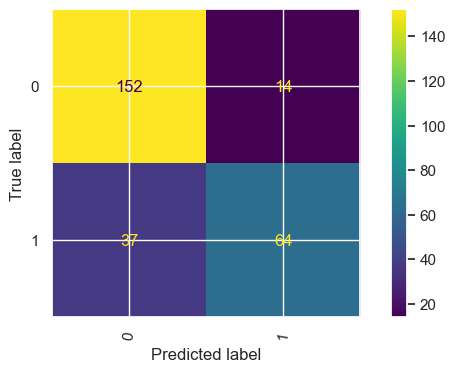

[0.99, 0.84, 0.94, 0.81, 0.94, 0.81, 0.94, 0.81, 0.94, 0.8]

In [65]:
rf = RandomForestClassifier()
params_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'class_weight': [None, 'balanced']
}
grid_search_rf = grid_search(rf, folds, params_grid, scoring= "accuracy")
grid_search_rf.fit(X_train, y_train)
print_best_score_params(grid_search_rf)
display_classification_report(model=grid_search_rf,
                              name_model="RandomForestClassifierCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo de Redes neuronales artificiales con GridSearchCV

Fitting 5 folds for each of 64 candidates, totalling 320 fits


INFO:__main__:ROC AUC Score Train: 0.95
INFO:__main__:ROC AUC Score Test: 0.84


Best Score:  0.8575200418264203
Best Hyperparameters:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 'auto', 'early_stopping': False, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'adam'}
Train Accuracy:  0.89
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.93      0.90       379
           1       0.93      0.85      0.89       379

    accuracy                           0.89       758
   macro avg       0.89      0.89      0.89       758
weighted avg       0.89      0.89      0.89       758

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       166
           1       0.81      0.66      0.73       101

    accuracy                           0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.81       267



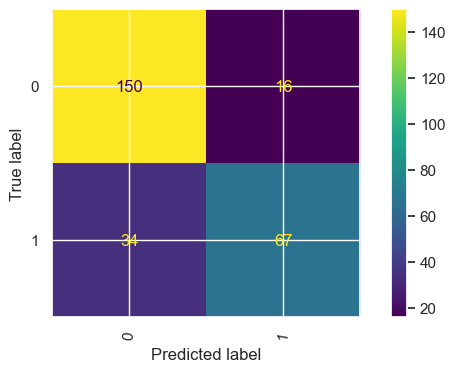

[0.95, 0.84, 0.89, 0.81, 0.89, 0.81, 0.89, 0.81, 0.89, 0.81]

In [66]:
mlp = MLPClassifier()
params_grid = {
    'hidden_layer_sizes': [(100,), (50,), (100, 50), (50, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200],
    'batch_size': ['auto', 50],
    'early_stopping': [True, False]
}

grid_search_mlp = grid_search(mlp, folds, params_grid, scoring= "accuracy")
grid_search_mlp.fit(X_train, y_train)
print_best_score_params(grid_search_mlp)
display_classification_report(model=grid_search_mlp,
                              name_model="MLPClassifierCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)